
This is an interactive version of the Multidimensional Sexual Self-Concept Questionnaire.

Introduction
Sexual self-concept is a persons own view of their sexual behaviours and actions.

The MSSCQ was created by Dr. William E. Snell, Jr. in 1995 for the general study of sexuality. It measures along twenty separate scales.

Procedure
The inventory consists of one hundred statements that must be rated on how characteristic they are of the subject. The test should not take most people more than eight minutes.

---



---




#Import

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


pd.set_option('display.max_colwidth', 100)
%matplotlib inline

# These are the files that come in the zip file for the Multidimensional Sexual Self-Concept Questionnaire
# Related paper: https://www.researchgate.net/publication/297734323_Multidimensional_Sexual_Self-Concept_Questionnaire
# The zip was found at: https://openpsychometrics.org/_rawdata/ 
# The zip can be downloaded at: http://openpsychometrics.org/_rawdata/MSSCQ.zip
# The survery can be taken at: https://openpsychometrics.org/tests/MSSCQ.php


survey_url = 'https://docs.google.com/spreadsheets/d/1EVsI6xR6q31xh5ByAWcWKa-A20JsSZYu2q98yrQgHc8/export?format=csv'

df = pd.read_csv(survey_url)

## Helpers

In [ ]:
def top_corrs(df, column, n=10):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(10)
    return top_n_num

def rand_index_score(grount_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(grount_truths), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(grount_truths), 2).sum()
    A = np.c_[(grount_truths, predictions)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(grount_truths))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)


#Summary

In [ ]:
print(f'The dataframe has {df.shape[0]} rows and {df.shape[::]} columns')

print(f'The dataframe has the following subclasses of gender: {df.gender.nunique()}.\nGenders represented by respondents:{df.gender.unique()}\n')
print(f'gender - Chosen from a drop down:\n(1=male, 2=female, 3=other, 0=failed to choose)\n\nage - entered into a text field (ages < 13 removed)\n')


print(f'The items Q1 through Q100 were rated on a scale where\n1=Not at all characteristic of me\n2=Slightly characteristic of me\n3=Somewhat characteristic of me\n4=Moderately characteristic of me\n5=Very characteristic of me\n')
print(f'The following question was asked, "I responded to the above items based on":\n1=A current sexual relationship\n2=A past sexual relationship\n3=An imagined sexual relationship\n')

The dataframe has 17685 rows and (17685, 102) columns
The dataframe has the following subclasses of gender: 4.
Genders represented by respondents:[1 2 0 3]

gender - Chosen from a drop down:
(1=male, 2=female, 3=other, 0=failed to choose)

age - entered into a text field (ages < 13 removed)

The items Q1 through Q100 were rated on a scale where
1=Not at all characteristic of me
2=Slightly characteristic of me
3=Somewhat characteristic of me
4=Moderately characteristic of me
5=Very characteristic of me

The following question was asked, "I responded to the above items based on":
1=A current sexual relationship
2=A past sexual relationship
3=An imagined sexual relationship



#Peak

In [ ]:
df.head(5)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,...,Q63,Q64,Q65,Q66,Q67,Q68,Q69,Q70,Q71,Q72,Q73,Q74,Q75,Q76,Q77,Q78,Q79,Q80,Q81,Q82,Q83,Q84,Q85,Q86,Q87,Q88,Q89,Q90,Q91,Q92,Q93,Q94,Q95,Q96,Q97,Q98,Q99,Q100,age,gender
0,3,2,5,5,1,2,2,1,1,2,2,3,3,1,1,5,1,2,4,3,3,2,4,5,1,1,2,1,1,1,3,3,3,1,1,5,1,3,5,4,...,4,5,2,1,5,3,2,2,4,3,2,1,1,5,5,3,5,3,4,4,4,5,1,1,4,4,1,3,4,2,4,1,1,5,5,3,5,4,23,1
1,5,1,5,1,1,2,1,3,1,1,1,4,1,2,1,1,5,1,5,2,0,1,4,2,1,1,1,2,2,4,1,2,1,1,1,1,5,1,4,4,...,3,3,1,1,1,3,1,5,1,2,1,1,1,1,1,1,5,2,5,2,4,2,1,1,1,2,1,2,1,1,1,1,1,2,1,1,5,3,25,2
2,1,4,5,5,1,4,5,5,5,4,5,5,5,4,2,5,1,4,1,5,1,5,5,5,2,1,2,5,4,4,4,4,5,4,2,5,2,4,2,4,...,5,5,2,2,4,2,4,2,5,5,5,5,1,5,4,4,1,5,1,4,5,5,1,2,4,1,1,4,5,5,5,5,1,5,4,4,1,4,20,1
3,5,4,5,5,5,5,2,4,5,5,5,2,5,1,1,5,1,4,5,1,5,3,5,4,5,0,1,5,1,1,5,2,3,1,1,5,1,4,5,4,...,5,5,5,5,5,3,2,1,4,5,5,1,3,5,5,5,2,4,2,4,5,5,5,5,4,4,2,5,4,4,4,1,2,5,0,4,5,5,23,2
4,4,5,4,5,4,2,3,2,4,5,1,3,4,3,3,1,5,2,5,3,5,3,3,5,3,1,2,2,4,4,1,1,1,1,4,1,4,1,4,4,...,3,5,2,0,3,3,2,4,2,4,2,2,4,1,1,1,1,3,4,3,3,4,1,2,2,3,3,4,1,3,1,1,3,1,1,1,4,3,50,2


## Data munging

In [ ]:
# Create mapper to make gender column readable
gender_map = {1: 'male', 
              2: 'female', 
              3: 'other', 
              0: 'failed to choose'}

#replace gender values from original df
df['gender'] = df['gender'].replace(gender_map)

#dtypes
df.info()

#convert gender col to str
df['gender'] = df.gender.astype('string')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17685 entries, 0 to 17684
Columns: 102 entries, Q1 to gender
dtypes: int64(101), object(1)
memory usage: 13.8+ MB


## Missing Values

In [ ]:
#check for missing vals
df.isna().mean().sort_values(ascending=False).head()

gender    0.0
Q38       0.0
Q28       0.0
Q29       0.0
Q30       0.0
dtype: float64

### Outliers - Z Scores

In [ ]:
from scipy.stats import zscore
z_scores = zscore(df_copy.age)
for threshold in range(1,5):
    print("The score threshold is: {}".format(threshold))
    print("The indices of the outliers:")
    print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))

The score threshold is: 1
The indices of the outliers:
(array([    4,     5,     6, ..., 17635, 17640, 17664]),)
Number of outliers is: 2779
The score threshold is: 2
The indices of the outliers:
(array([    4,     5,     6, ..., 17595, 17628, 17634]),)
Number of outliers is: 1114
The score threshold is: 3
The indices of the outliers:
(array([   44,   157,   327,   337,   350,   378,   402,   406,  1475,
        1494,  1524,  1760,  1858,  1904,  1960,  1975,  2060,  2082,
        2085,  2319,  2408,  2423,  2640,  2670,  2750,  2828,  2871,
        2953,  2954,  3071,  3087,  3219,  3244,  3318,  3415,  3569,
        3576,  3628,  3635,  3638,  3646,  3823,  3855,  3867,  3900,
        3916,  3976,  4099,  4199,  4239,  4386,  4456,  4688,  4763,
        4767,  4869,  5034,  5254,  5270,  5271,  5310,  5457,  5600,
        5784,  5794,  6104,  6114,  6121,  6151,  6228,  6270,  6284,
        6389,  6395,  6399,  6419,  6469,  6578,  6747,  6763,  6784,
        6848,  6866,  7166,  721

In [ ]:
!pip install sweetviz

### Assessing Target Variable - Age & Categorical Variable - Gender

In [ ]:
#found in previous analysis
bad_ages = [125, 150, 200, 222, 236, 265, 378, 400, 1995, 9599, 9877, 8346346]
df = df[~df['age'].isin(bad_ages)]

# make copy of df
df_copy = df.copy()
# make new df with gender and age columns
gender_age = df_copy[['age', 'gender']]
# make new df with question columns
questions = df_copy.drop(['age', 'gender'], axis=1)

# check age for weird values
gender_age.describe()

,age
count,17673.000000
mean,26.378826
std,11.123267
min,13.000000
25%,19.000000
50%,22.000000
75%,31.000000
max,100.000000


Target variable statistics:

* Avg Age: 26.37	
* Standard Deviation: 11.12	
* Mininum age: 13.0 	
* 25th Percentile: 19.0 	
* 50th Percentile: 22.0 	
* 75th Percentile: 31.0 	
* Maximum Age: 100.0



Distribution of Target Variable

In [ ]:
# print(pd.crosstab(gender_age.gender, gender_age.age).max().sort_values(ascending=False))
# print(pd.crosstab(gender_age.gender, gender_age.age).max().sort_values(ascending=True))

Top 5 Sub-classes of respondents - Age:
* Age 18 - 1051 respondents
* Age 19 - 851 respondents
* Age 17 - 738 respondents
* Age 20 - 721 respondents
* Age 21 - 680 respondents

Bottom 5 Sub-classes of respondents - Age:
* Age 100 - 1 respondent
* Age 73 - 1 respondent
* Age 74 - 1 respondent
* Age 76 - 1 respondent
* Age 77 -  respondent

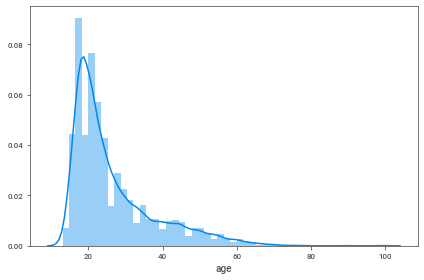

In [ ]:
sns.distplot(gender_age['age'])
plt.tight_layout()
plt.show()


#EDA

### Univariate Analysis of Continous Variable - Age

ValueError: ignored

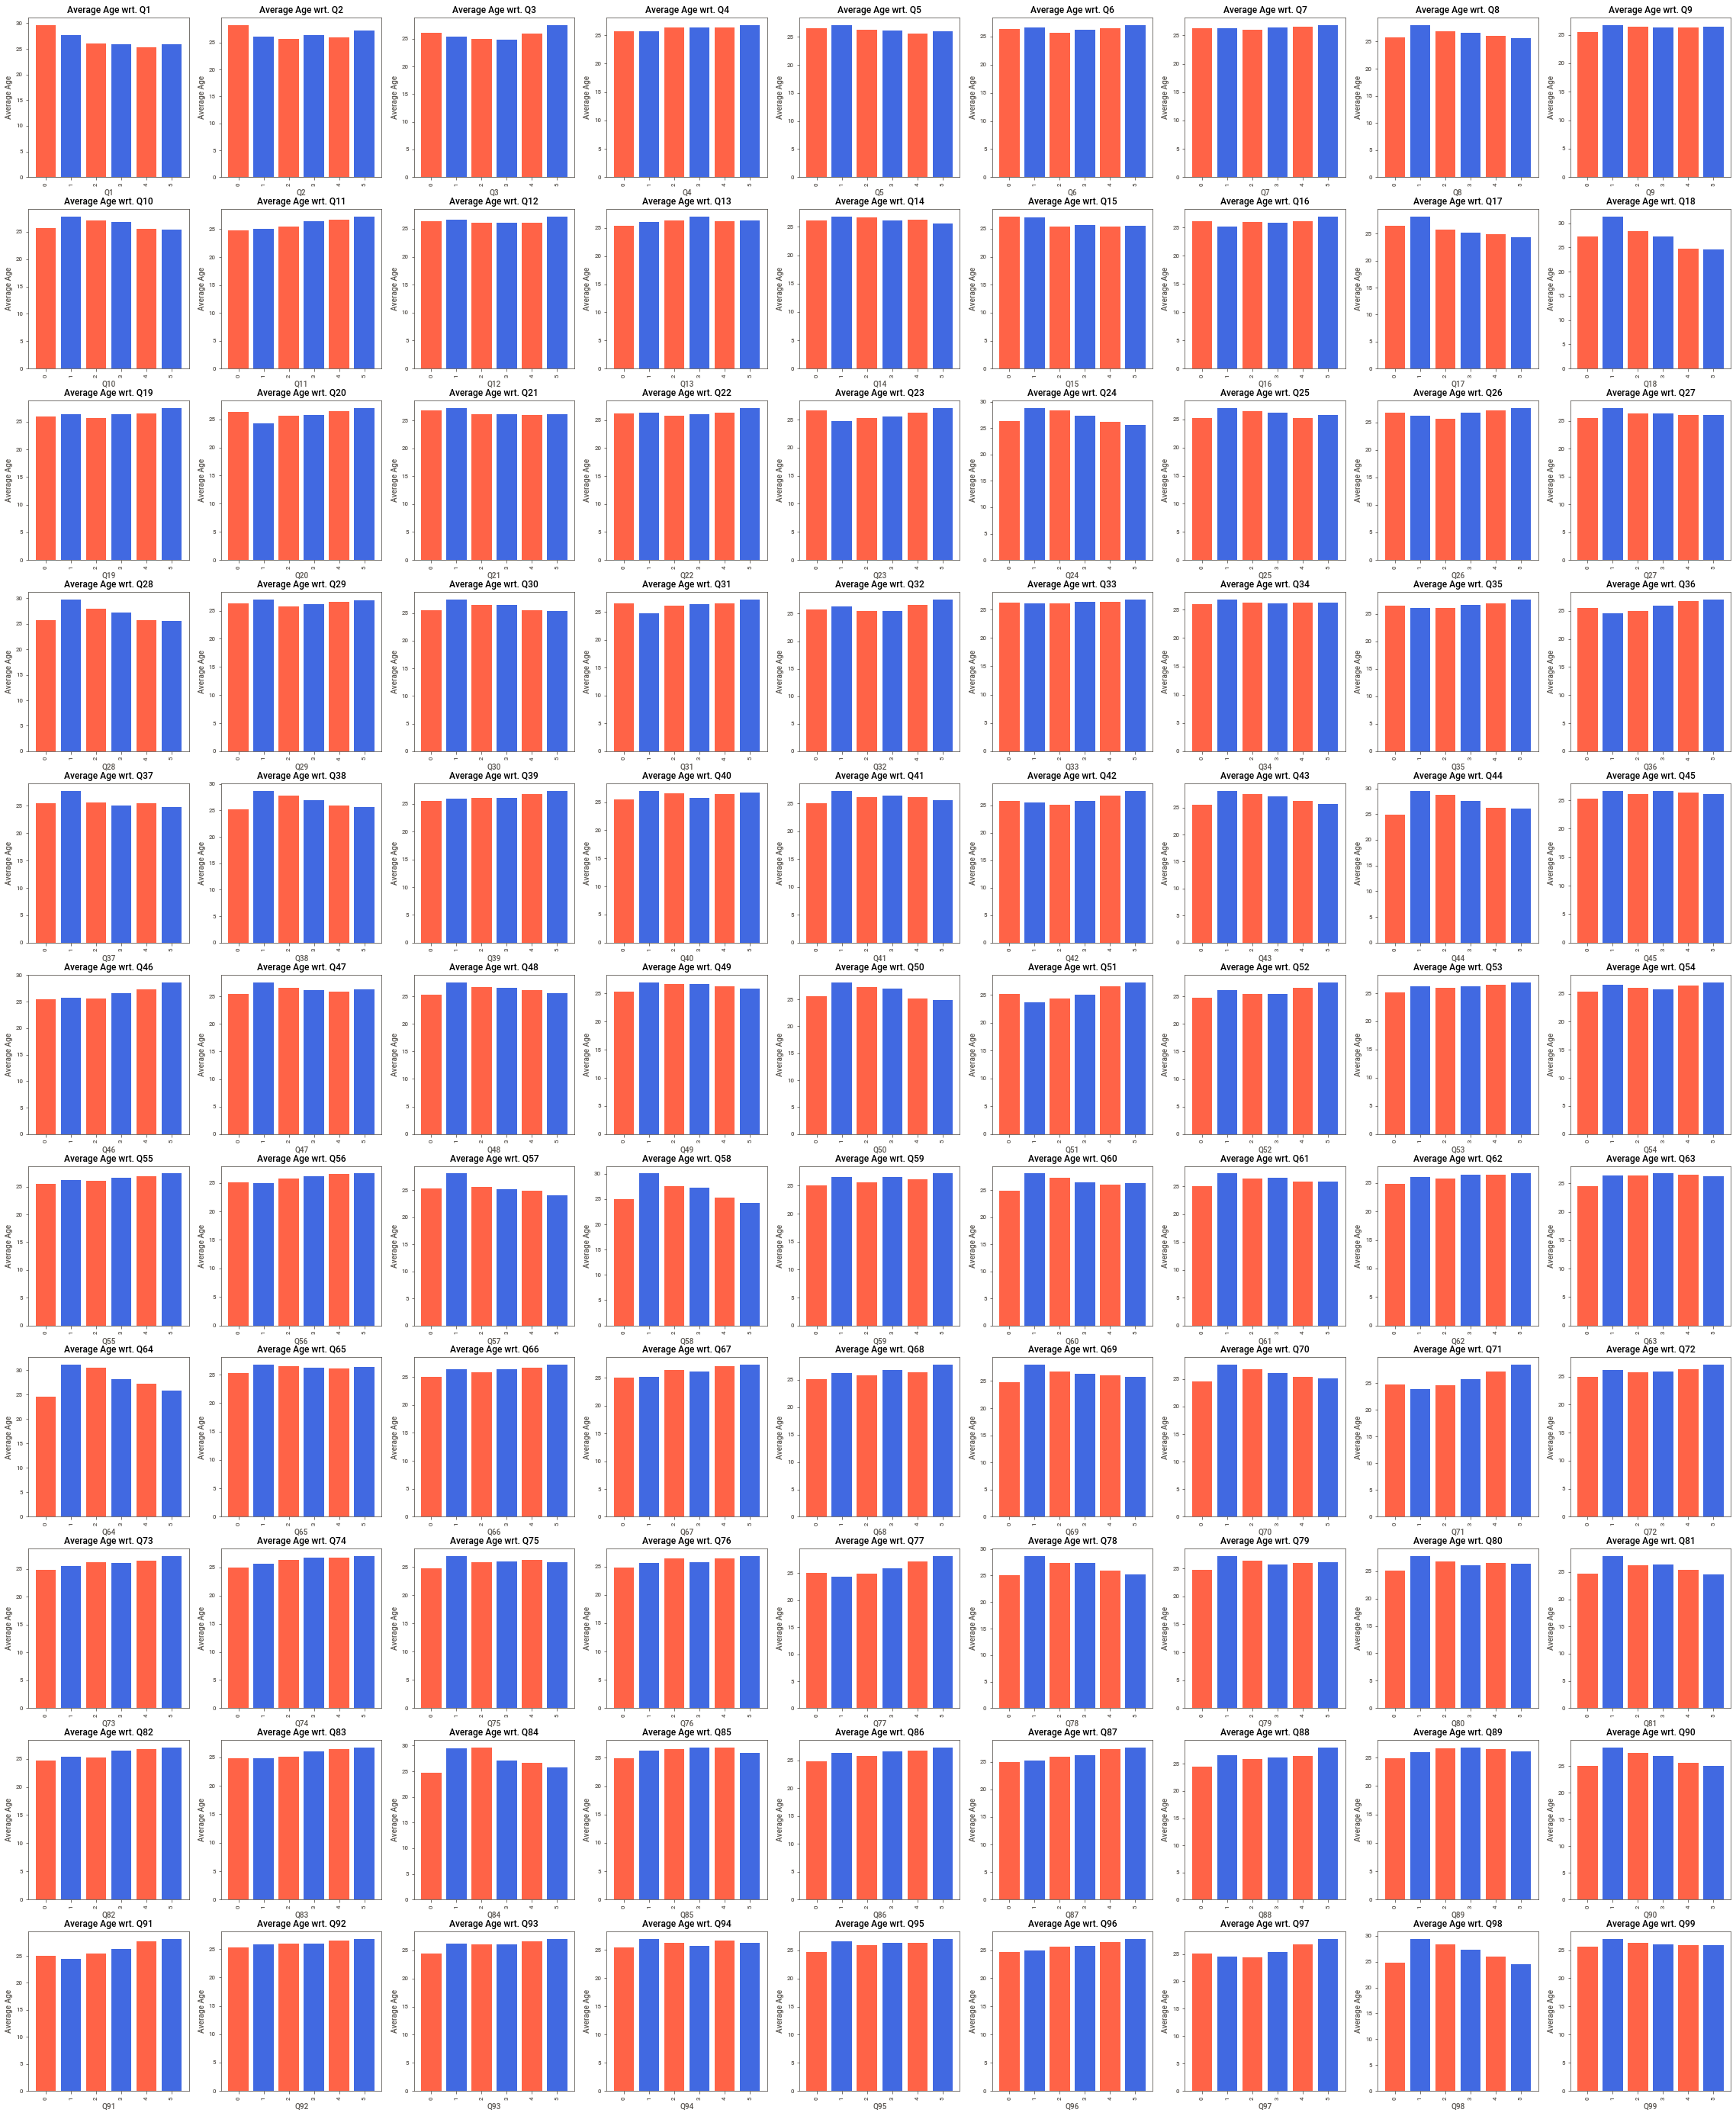

In [ ]:
plt.figure(figsize=(40,50))
for index, column in enumerate(df_copy.iloc[:, :-1]):
    ax = plt.subplot(11,9,index+1)
    plt.bar(df_copy.groupby(column)["age"].mean().index, 
            df_copy.groupby(column)["age"].mean(),
           color=("tomato","royalblue"))
    plt.title("Average Age wrt. {}".format(column))
    plt.ylabel("Average Age")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

Judging from the distribution of the independent variables, there's a sense of "dents" or jaggedness througout.  This lack of continuity could create problems in model accuracy. 

The bar charts above provide some insight into shape and behavior of the target class. The top 4 most correlated features show moderate to high right skewing.

In [ ]:
df_copy.groupby('age')['Q58', 'Q57', 'Q91', 'Q97', 'Q51'].mean().plot(kind='bar', figsize=(45,15))
plt.tight_layout()
plt.title('Bar Graph of Bottom-5 of 10 Most Correlated Questions by Age');

Below are the scatter plots for the highest correlated values.  We note some features with outliers usually near age 90 +/- 10 years of age. 



### Gender - Class membership

In [ ]:
plt.figure(figsize=(15,5))
plt.barh(df_copy.groupby("gender")["gender"].count().index, 
        df_copy.groupby("gender")["gender"].count(), 
        color=["red","green","blue","grey","pink"])
plt.title("Bar Chart of Gender totals per subclass\n")

plt.show()

# Correlation Matrix - Age versus Correalated Features

###Correalation - Questions vs. Age

In [ ]:
def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()
top_n_corrs = top_corrs(df_copy, 'age')
# log_top_n_corrs = top_corrs(log_df, "log_saleprice")
top_n_corrs


In [ ]:
plot_top_corrs(df_copy, 'age')

In [ ]:
outliers_ga = gender_age[gender_age['age'] >= 90].sort_values(by='age')
outliers_ga.T

In [ ]:
df_copy.groupby('age')['Q18', 'Q71', 'Q77', 'Q17'].sum().plot(kind='bar', figsize=(10,15))
plt.tight_layout()
plt.title('Bar Graph of Top 4 Correlated Questions by Age');

# Modeling

In [ ]:
X = df_copy.iloc[:, :-2]
y = df_copy.age #target

# Standardizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# n_components = 102
pca = PCA()
pca.fit(X_std)

X_std_pca = pca.transform(X_std)

In [ ]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_std_pca,
    test_size=0.5,
    random_state=13579)

In [ ]:
X.loc[1]

Q1      5
Q2      1
Q3      5
Q4      1
Q5      1
       ..
Q96     2
Q97     1
Q98     1
Q99     5
Q100    3
Name: 1, Length: 100, dtype: int64

###$ K = 4

1 loop, best of 3: 2.67 s per loop


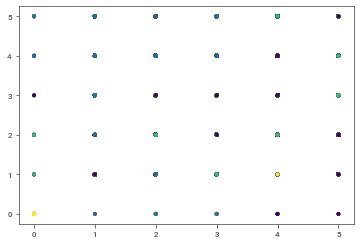

0.12223916688875738


(4, 100)

In [ ]:
k_means = KMeans(n_clusters=4, random_state=42)
%timeit k_means.fit(X_std_pca)
y_pred = k_means.predict(X_std_pca)

plt.scatter(df_copy.iloc[:,0], df_copy.iloc[:,1], c=y_pred)
plt.show()

clusters = k_means.fit_predict(X_std_pca)
k_means.cluster_centers_.shape


labels = k_means.labels_
print(metrics.silhouette_score(X_std_pca, labels, metric='euclidean'))

##### Predicted Clusters k=4, Rand Index & Adjust Rand Index

In [ ]:
#predicted clusters
full_pred_4 = KMeans(n_clusters=4, random_state=42).fit_predict(X_std_pca)
pd.crosstab(y, full_pred).head(3)

col_0,0,1,2,3
age,,,,
13,20,12,7,1
14,50,60,55,18
15,132,150,158,21


In [ ]:
#contingency table
full_pred_4 = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred_4])
pd.crosstab(y, full_pred_4).head(3)

col_0,0,1,2
age,,,
13,12,20,8
14,60,50,73
15,150,132,179


In [ ]:
rand_index_score(y, full_pred_4)

0.9433326476203415

In [ ]:
metrics.adjusted_rand_score(y, full_pred_4)

-0.0007577718495891988

##k = 3

1 loop, best of 3: 2.24 s per loop


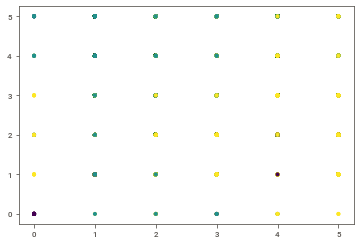

col_0,0,1,2
age,,,
13,1,15,24
14,18,80,85
15,22,196,243
16,46,434,427
17,39,507,614
...,...,...,...
89,1,0,0
90,1,1,0
98,0,1,0


In [ ]:
k_means = KMeans(n_clusters=3, random_state=42)
%timeit k_means.fit(X_std_pca)
y_pred = k_means.predict(X_std_pca)

clusters = k_means.fit_predict(X_std_pca)
k_means.cluster_centers_.shape
accuracy_score(y, labels)


plt.scatter(df_copy.iloc[:,0], df_copy.iloc[:,1], c=y_pred)
plt.show()

##### Predicted clusters k=3

In [ ]:
#predicted clusters
full_pred_3 = KMeans(n_clusters=3, random_state=42).fit_predict(X_std_pca)
pd.crosstab(y, full_pred_3).head(3)

col_0,0,1,2
age,,,
13,1,15,24
14,18,80,85
15,22,196,243


In [ ]:
#contingency table
full_pred_3 = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred_3])
pd.crosstab(y, full_pred_3).head(3)

col_0,0,1,2
age,,,
13,15,1,24
14,80,18,85
15,196,22,243


In [ ]:
clusters = k_means.fit_predict(X_std_pca)
k_means.cluster_centers_.shape
labels = k_means.labels_
print(metrics.silhouette_score(X_std_pca, labels, metric='euclidean'))

0.15771890365626445


In [ ]:
labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std_pca)
print(metrics.silhouette_score(X_std_pca, labels, metric='euclidean'))

0.16621891296541902


##### k=2

1 loop, best of 3: 1.2 s per loop


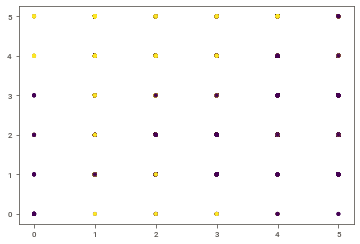

0.1523890154739794


In [ ]:
k_means = KMeans(n_clusters=2, random_state=42)
%timeit k_means.fit(X_std_pca)
y_pred = k_means.predict(X_std_pca)

plt.scatter(df_copy.iloc[:,0], df_copy.iloc[:,1], c=y_pred)
plt.show()

clusters = k_means.fit_predict(X_std_pca)
k_means.cluster_centers_.shape


labels = k_means.labels_
print(metrics.silhouette_score(X_std_pca, labels, metric='euclidean'))

In [ ]:
#predicted clusters
full_pred_2 = KMeans(n_clusters=2, random_state=42).fit_predict(X_std_pca)
pd.crosstab(y, full_pred_2).head(3)



In [ ]:
#contingency table
full_pred_2 = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred_2])
pd.crosstab(y, full_pred_2).head(3)

In [ ]:
clusters = k_means.fit_predict(X_std_pca)
k_means.cluster_centers_.shape
labels = k_means.labels_
print(metrics.silhouette_score(X_std_pca, labels, metric='euclidean'))

In [ ]:
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std_pca)
print(metrics.silhouette_score(X_std_pca, labels, metric='euclidean'))

0.1523796723744475


###Agglomerative Clustering

In [ ]:
n_clusters = 4
ward = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward') 
ward.fit(X_std_pca)

ward_pred = ward.fit_predict(X_std_pca)

#distance calculation
preds = ward.fit_predict(X_std_pca)
score = silhouette_score(X_std_pca, full_pred_4, metric='l2')
print(score)

In [ ]:
n_clusters = 3
ward = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward') 
ward.fit(X_std)

ward_pred = ward.fit_predict(X_std)

#distance calculation
preds = ward.fit_predict(X_std)
score = silhouette_score(X_std, full_pred_3, metric='l2')
print(score)

In [ ]:
n_clusters = 2
ward = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward') 
ward.fit(X_std_pca)

ward_pred = ward.fit_predict(X_std_pca)

#distance calculation
preds = ward.fit_predict(X_std_pca)
score = silhouette_score(X_std_pca, full_pred_2, metric='l2')
print(score)

##### Questions

In [ ]:
questions = ["I feel anxious when I think about the sexual aspects of my life.					",
"I have the ability to take care of any sexual needs and desires that I may have.					",
"I am very aware of my sexual feelings and needs.					",
"I am motivated to avoid engaging in \"risky\" (i.e., unprotected) sexual behavior.					",
"The sexual aspects of my life are determined mostly by chance happenings.					",
"I think about sex \"all the time.\"					",
"I’m very assertive about the sexual aspects of my life.					",
"I expect that the sexual aspects of my life will be positive and rewarding in the future.					",
"I would be to blame, if the sexual aspects of my life were not going very well.					",
"I notice how others perceive and react to the sexual aspects of my life.					",
"I’m motivated to be sexually active.					",
"If I were to experience a sexual problem, I myself would in control of whether this improved.					",
"I derive a sense of self-pride from the way I handle my own sexual needs and desires.					",
"I am satisfied with the way my sexual needs are currently being met.					",
"My sexual behaviors are determined largely by other more powerful and influential people.					",
"Not only would I be a good sexual partner, but it’s quite important to me that I be a good sexual partner.					",
"I am afraid of becoming sexual involved with another person.					",
"If I am careful, then I will be able to prevent myself from having any sexual problems.					",
"I am depressed about the sexual aspects of my life.					",
"My sexuality is something that I am largely responsible for.					",
"I worry about the sexual aspects of my life.					",
"I am competent enough to make sure that my sexual needs are fulfilled.					",
"I am very aware of my sexual motivations and desires.					",
"I am motivated to keep myself from having any \"risky\" sexual behavior (e.g., exposure to sexual diseases).					",
"Most things that affect the sexual aspects of my life happen to me by accident.					",
"I think about sex more than anything else.					",
"I’m not very direct about voicing my sexual needs and preferences.					",
"I believe that in the future the sexual aspects of my life will be healthy and positive.					",
"If the sexual aspects of my life were to go wrong, I would be the person to blame.					",
"I’m concerned with how others evaluate my own sexual beliefs and behaviors.					",
"I’m motivated to devote time and effort to sex.					",
"If I were to experiences a sexual problem, my own behavior would determine whether I improved.					",
"I am proud of the way I deal with and handle my own sexual desires and needs.					",
"I am satisfied with the status of my own sexual fulfillment.					",
"My sexual behaviors are largely controlled by people other than myself (e.g., my partner, friends, family).					",
"Not only would I be a skilled sexual partner, but it’s very important to me that I be a skilled sexual partner.					",
"I have a fear of sexual relationships.					",
"I can pretty much prevent myself from developing sexual problems by taking good care of myself.					",
"I am disappointed about the quality of my sex life.					",
"The sexual aspects of my life are determined in large part by my own behavior.					",
"Thinking about the sexual aspects of my life often leaves me with an uneasy feeling.					",
"I have the skills and ability to ensure rewarding sexual behaviors for myself.					",
"I tend to think about my own sexual beliefs and attitudes.					",
"I want to avoid engaging in sex where I might be exposed to sexual diseases.					",
"Luck plays a big part in influencing the sexual aspects of my life.					",
"I tend to be preoccupied with sex.					",
"I am somewhat passive about expressing my own sexual desires.					",
"I do not expect to suffer any sexual problems or frustrations in the future.					",
"If I were to develop a sexual disorder, then I would be to blame for not taking good care of myself.					",
"I am quick to notice other people’s reactions to the sexual aspects of my own life.					",
"I have a desire to be sexually active.					",
"If I were to become sexually maladjusted, I myself would be responsible for making myself better.					",
"I am pleased with how I handle my own sexual tendencies and behaviors.					",
"The sexual aspects of my life are personally gratifying to me.					",
"My sexual behavior is determined by the actions of powerful others (e.g., my partner, friends, family).					",
"Not only could I relate well to a sexual partner, but it’s important to me that I be able to do so.					",
"I am fearful of engaging sexual activity.					",
"If just I look out for myself, then I will be able to avoid any sexual problems in the future.					",
"I feel discouraged about my sex life.					",
"I am in control of and am responsible for the sexual aspects of my life.					",
"I worry about the sexual aspects of my life.					",
"I am able to cope with and to handle my own sexual needs and wants.					",
"I’m very alert to changes in my sexual thoughts, feelings, and desires.					",
"I really want to prevent myself from being exposed to sexual diseases.					",
"The sexual aspects of my life are largely a matter of (good or bad) fortune.					",
"I’m constantly thinking about having sex.					",
"I do not hesitate to ask for what I want in a sexual relationship.					",
"I will probably experience some sexual problems in the future.					",
"If I were to develop a sexual problem, then it would be my own fault for letting it happen.					",
"I’m concerned about how the sexual aspects of my life appear to others.					",
"It’s important to me that I involve myself in sexual activity.					",
"If I developed any sexual problems, my recovery would depend in large part on what I myself would do.					",
"I have positive feelings about the way I approach my own sexual needs and desires.					",
"The sexual aspects of my life are satisfactory, compared to most people’s.					",
"In order to be sexually active, I have to conform to other more powerful individuals.					",
"I am able to \"connect\" well with a sexual partner, and it’s important to me that I am able to do so.					",
"I don’t have much fear about engaging in sex.					",
"I will be able to avoid any sexual problems, if I just take good care of myself.					",
"I feel unhappy about my sexual experiences.					",
"The main thing which affects the sexual aspects of my life is what I myself do.					",
"I feel nervous when I think abut the sexual aspects of my life.					",
"I have the capability to take care of my own sexual needs and desires.					",
"I am very aware of the sexual aspects of myself (e.g. habits, thoughts, beliefs).					",
"I am really motivated to avoid any sexual activity that might expose me to sexual diseases.					",
"The sexual aspects of my life are a matter of fate (destiny).					",
"I think about sex the majority of the time.					",
"When it comes to sex, I usually ask for what I want.					",
"I anticipate that in the future the sexual aspects of my life will be frustrating.					",
"If something went wrong with my own sexuality, then it would be my own fault.					",
"I’m aware of the public impression created by my own sexual behaviors and attitudes.					",
"I strive to keep myself sexually active.					",
"If I developed a sexual disorder, my recovery would depend on how I myself dealt with the problem.					",
"I feel good about the way I express my own sexual needs and desires.					",
"I am satisfied with the sexual aspects of my life.					",
"My sexual behavior is mostly determined by people who have influence and control over me.					",
"Not only am I be capable of relating to a sexual partner, but it’s important to me that I relate very well.					",
"I’m not afraid of becoming sexually active.					",
"If I just pay careful attention, I’ll be able to prevent myself from having any sexual problems.					",
"I feel sad when I think about my sexual experiences.					",
"My sexuality is something that I myself am in charge of."]


In [ ]:
# transpose cc df 
# add questions text to df 

In [ ]:
# row 2 - row1 

cc.head()



In [ ]:
cc = cc.T

cc['question'] = questions

cc['diff01'] = (cc[0] - cc[1]).abs()

cc['diff02'] = (cc[0] - cc[2]).abs()

cc['diff12'] = (cc[1] - cc[2]).abs()


In [ ]:
cc.sort_values(by='diff01', ascending=False)

In [ ]:
cc = pd.DataFrame(kmeans.cluster_centers_)

In [ ]:
cc.hist();

In [ ]:
cc.describe()

In [ ]:
display (cc.sort_values(by='diff02', ascending=False).head())

cc.sort_values(by='diff12', ascending=False).head()

#add right trim

#Conclusion

Most effective method maintains KMeans and Agglomerative Clustering.  Per the research documentation, the accuracy of scores, etc...do need further investigation; as it may be pressumed that the inventory held task to collect, identify, observe for discussion. As researchers mentioned, further insights will require research beyond tests performed by author. Notwithstanding, author observes dataset is very analytics heavy and may be better suited for statistical or data visualization.

Author will revise accordingly to reflect more robust visualization piece, however, the pyton package "Sweet Viz" fell inoperable due to size of dataset.

Limitations included:

* class imbalances
* inauthority on best practice to normalize feature 'Age'
* exhaustive sweep of questionaire base
* test/user and other errors on discovery.

While there's still room for growth, the project may be better aided with deeper investigation put towards alternate ways to broadcast original researcher message. 